# Задача поиска похожих поддеревьев в синтаксическом дереве.

    Сравнивается работа оптимального метода нахождения полных повторов с менее оптимальным по скорости методом, но учитывающим свободный порядок слов на одном уровне в предложении.

In [42]:
import os
import time
from collections import defaultdict
from itertools import combinations
import matplotlib.pyplot as plt
import pandas as pd
from gensim.models import Word2Vec
from collections import defaultdict
import numpy as np
from queue import LifoQueue
import itertools

Чтение файлов с синтаксическими деревьями, сгенерированными парсером PaRus, удаление пунктуационных связей и некоторых ошибок.

In [20]:
def read_data():
    DATA_PATH = r'parus_results'
    files = os.listdir(DATA_PATH)
    trees_df = pd.DataFrame(columns=['id', 'form', 'lemma', 'upostag', 'xpostag', 'feats', 'head', 'deprel'])

    for file in files:
        full_dir = os.path.join(DATA_PATH, file)
        name = file.split('.')[0]
        with open(full_dir, encoding='utf-8') as f:
            this_df = pd.read_csv(f, sep='\t',
                                  names=['id', 'form', 'lemma', 'upostag', 'xpostag', 'feats', 'head', 'deprel'])
            if this_df['id'].duplicated().any():
                start_of_subtree_df = list(this_df.groupby(this_df.id).get_group(1).index)
                boundaries = start_of_subtree_df + [max(list(this_df.index)) + 1]
                list_of_dfs = [this_df.iloc[boundaries[n]:boundaries[n + 1]] for n in range(len(boundaries) - 1)]
                local_counter = 1
                for df in list_of_dfs:
                    df['sent_name'] = name + '_' + str(local_counter)
                    trees_df = pd.concat([trees_df, df], ignore_index=True)
                    local_counter += 1
            else:
                this_df['sent_name'] = name
                trees_df = pd.concat([trees_df, this_df], ignore_index=True)

    # delete useless data
    trees_df = trees_df.drop(columns=['upostag', 'xpostag', 'feats'], axis=1)
    trees_df.drop(index=[11067], inplace=True)
    trees_df.loc[13742, 'deprel'] = 'разъяснит'

    # delete relations of type PUNC and reindex
    trees_df_filtered = trees_df[trees_df.deprel != 'PUNC']
    trees_df_filtered = trees_df_filtered.reset_index(drop=True)
    trees_df_filtered.index = trees_df_filtered.index + 1
    return trees_df_filtered

В задаче ищутся фразы не на основании эквивалентности, а на основании похожести. Используется модель word2vec, натренированная на том же корпусе. 
Например, здесь в один класс попадают "плановый", "экстренный" и опечатка в слове "плановый", когда речь идет о порядке:

#### 466: [(466, 'в', '31635_7'), (468, 'порядке', '31635_7'), (467, 'планвом', '31635_7')]
#### 1533: [(1533, 'в', '33362_5'), (1535, 'порядке', '33362_5'), (1534, 'плановом', '33362_5')]
#### 3713: [(3713, 'в', '37462_102'), (3715, 'порядке', '37462_102'), (3714, 'экстренном', '37462_102')]
#### 3826: [(3826, 'в', '37462_37'), (3828, 'порядке', '37462_37'), (3827, 'экстренном', '37462_37')]

Разные названия диагнозов:
#### 1042: [(1042, 'с', '32384_3'), (1043, 'диагнозом', '32384_3'), (1044, 'ИБС', '32384_3')]
#### 1525: [(1525, 'с', '33362_2'), (1526, 'диагнозом', '33362_2'), (1527, 'ИНРС', '33362_2')]
#### 1612: [(1612, 'с', '33445_4'), (1613, 'диагнозом', '33445_4'), (1614, 'ИБС', '33445_4')]
#### 3822: [(3822, 'с', '37462_27'), (3823, 'диагнозом', '37462_27'), (3824, 'ИБС', '37462_27')]
#### 3956: [(3956, 'с', '37462_92'), (3957, 'диагнозом', '37462_92'), (3958, 'ИБС', '37462_92')]

Синонимы "диагностировать" и "зафиксировать":
#### 1022: [(1022, 'когда', '32384_1'), (1024, 'была', '32384_1'), (1023, 'впервые', '32384_1'), (1025, 'диагностирована', '32384_1'), (1026, 'стенокардия', '32384_1'), (1027, 'напряжения', '32384_1')]
#### 3151: [(3151, 'когда', '35854_0'), (3153, 'был', '35854_0'), (3152, 'впервые', '35854_0'), (3154, 'зафиксирован', '35854_0'), (3155, 'пароксизм', '35854_0'), (3156, 'ФП', '35854_0')]

(примеры результатов алгоритма частичных повторов)

In [21]:
def train_word2vec(trees_df_filtered, lemmas):
    lemma_sent_df = trees_df_filtered[['lemma', 'sent_name']]
    lemma_sent_dict = {}
    for name, group in lemma_sent_df.groupby('sent_name'):
        lemma_sent_dict[name] = []
        for _, row in group.iterrows():
            lemma_sent_dict[name].append(row['lemma'])
    model = Word2Vec(list(lemma_sent_dict.values()), min_count=1)
    similar_dict = {}
    for lemma in lemmas:
        similar_dict[lemma] = model.most_similar(lemma)

Структуры: Вершина, Ребро, Дерево. Определенные на них для работы операции.

In [22]:
class Node:
    def __init__(self, id, lemma, form=None, sent_name=None):
        self.id = id
        self.lemma = lemma
        self.form = form
        self.sent_name = sent_name


class Edge:
    def __init__(self, node_id_from, node_id_to, weight):
        self.node_from = node_id_from
        self.node_to = node_id_to
        self.weight = weight  # relation type

In [23]:
class Tree:
    def __init__(self):
        self.edges = []
        self.nodes = []
        self.heights = []
        self.edges_dict_from = {}
        self.edges_dict_to = {}
        self.nodes_dict_id = {}

    def set_help_dict(self):
        self.edges_dict_from = {k: list(v) for k, v in itertools.groupby(sorted(self.edges, key=lambda x: x.node_from),
                                                                         key=lambda x: x.node_from)}
        self.nodes_dict_id = {node.id: node for node in self.nodes}
        self.edges_dict_to = {k: list(v)[0] for k, v in itertools.groupby(self.edges, key=lambda x: x.node_to)}

    def add_node(self, node):
        self.nodes.append(node)

    def add_edge(self, edge):
        self.edges.append(edge)

    def get_node(self, node_id):
        return self.nodes_dict_id.get(node_id)  # return Node class instance

    def get_children(self, node_id):
        edges = self.edges_dict_from.get(node_id)
        return list(map(lambda x: x.node_to, edges if edges is not None else []))

    def get_edge(self, to_id):
        return self.edges_dict_to.get(to_id)

    def remove_edge(self, to_id):
        self.edges = list(filter(lambda x: x.node_to != to_id, self.edges))

    # Функция подсчета высот для каждой вершины. В текущей версии поиск поддеревьев ведется на одной и той же высоте (те 
    # на одном уровне в предложении)
    
    def calculate_heights(self):
        visited = np.full(len(self.nodes), False, dtype=bool)
        self.heights = np.full(len(self.nodes), -1, dtype=int)  # all heights are -1 initially
        stack = LifoQueue()
        stack.put(0)
        prev = None
        while stack.qsize() > 0:
            curr = stack.get()
            stack.put(curr)
            if not visited[curr]:
                visited[curr] = True
            children = self.get_children(curr)
            if len(children) == 0:
                self.heights[curr] = 0
                prev = curr
                stack.get()
            else:
                all_visited_flag = True
                for child in children:
                    if not visited[child]:
                        all_visited_flag = False
                        stack.put(child)
                if all_visited_flag:
                    if len(children) > 1:
                        max_height = -1
                        for child in children:
                            if self.heights[child] > max_height:
                                max_height = self.heights[child]
                        curr_height = max_height + 1
                    else:
                        curr_height = self.heights[prev] + 1
                    self.heights[curr] = curr_height
                    prev = curr
                    stack.get()

    # Обход дерева - для записи результатов в файл. Результаты алгоритмов - набор вершин похожих поддеревьев, чтобы
    # восстановить цепочку слов для каждого, надо обойти поддерево в глубину из этой вершины.
    
    def simple_dfs(self, vertex):
        sequence = []
        node = self.get_node(vertex)
        if node is not None:
            sequence.append(tuple([vertex, node.form, node.sent_name]))
            visited = np.full(len(self.nodes), False, dtype=bool)
            stack = [vertex]
            while len(stack) > 0:
                curr = stack[-1]
                if not visited[curr]:
                    visited[curr] = True
                children = self.get_children(curr)
                if len(children) == 0:
                    stack.pop()
                else:
                    all_visited_flag = True
                    for child in children:
                        if not visited[child]:
                            all_visited_flag = False
                            stack.append(child)
                            node = self.get_node(child)
                            sequence.append(tuple([child, node.form, node.sent_name]))
                    if all_visited_flag:
                        stack.pop()
        return sequence

In [38]:
def construct_tree(trees_df_filtered, dict_lemmas, dict_rel):
    # construct a tree with a list of edges and a list of nodes
    whole_tree = Tree()
    root_node = Node(0, 0)  # add root
    Tree.add_node(whole_tree, root_node)
    for name, group in trees_df_filtered.groupby('sent_name'):
        row_ids = trees_df_filtered.index[trees_df_filtered.sent_name == name].to_list()
        # temporary dictionary for remapping indices
        temp_dict = {key: row_ids[ind] for ind, key in enumerate(group.id.to_list())}
        temp_dict[0] = 0
        for _, row in group.iterrows():
            new_id = temp_dict.get(row['id'])
            new_node = Node(new_id, dict_lemmas.get(row['lemma']), row['form'], row['sent_name'])
            Tree.add_node(whole_tree, new_node)
            new_edge = Edge(temp_dict.get(row['head']), new_id, dict_rel.get(row['deprel']))
            Tree.add_edge(whole_tree, new_edge)
    return whole_tree

Далее идет код для задачи поиска полных поддеревьев.

Вспомогательные методы по сортировке вершин-ребер внутри поддерева.

In [24]:
# input: map_dict - {v.id: str value of mapped string}
# returns: sorted_res - {v.id: str value of mapped string} in sorted order

def radix_sort(map_dict):
    if len(map_dict) == 0:
        return map_dict
    map_dict_rev = defaultdict(list)  # reversed: {str value of mapped string: [v.id]}
    for key, val in map_dict.items():
        map_dict_rev[val].append(key)
    n_digits = max(list(map(lambda x: len(x), map_dict_rev.keys())))  # max N of digits
    numbers = list(map_dict_rev.keys())
    b = numbers.copy()  # array for intermediate results_part
    upper_bound = 10
    for i in range(n_digits):
        c = np.zeros(upper_bound, dtype=int)  # temp array
        for j in range(len(numbers)):
            d = int(numbers[j]) // pow(10, i)
            c[d % 10] += 1
        cnt = 0
        for j in range(upper_bound):
            tmp = c[j]
            c[j] = cnt
            cnt += tmp
        for j in range(len(numbers)):
            d = int(numbers[j]) // pow(10, i)
            b[c[d % 10]] = numbers[j]
            c[d % 10] += 1
        numbers = b.copy()
    sorted_res = {list_item: number for number in numbers for list_item in map_dict_rev[number]}
    return sorted_res


# from https://stackoverflow.com/questions/18262306/quicksort-with-python
def quick_sort(array):
    less = []
    equal = []
    greater = []
    if len(array) > 1:
        pivot = array[0]
        for x in array:
            if x < pivot:
                less.append(x)
            elif x == pivot:
                equal.append(x)
            elif x > pivot:
                greater.append(x)
        return quick_sort(less) + equal + quick_sort(greater)
    else:
        return array


# input: remapped_dict - dictionary {v.id: int array of mapped string}
# returns: sorted_res - dictionary {v.id: str value of mapped string}
def sort_strings_inside(remapped_dict):
    sorted_res = {}
    for item in remapped_dict.items():
        sorted_array = quick_sort(item[1])
        sorted_res[item[0]] = "".join([str(digit) for digit in sorted_array])
    return sorted_res


def remap_s(str_dict):
    m = 0
    remapped = {key: "" for key in str_dict.keys()}  # key : node id, value: mapped string
    already_seen = {}
    for tpl in str_dict.items():
        for char in tpl[1]:
            if char in already_seen.keys():
                mapping = already_seen[char]
            else:
                m = m + 1
                already_seen[char] = m
                mapping = m
            remapped[tpl[0]] += str(mapping)
    remapped = {item[0]: np.array([int(item[1][p]) for p in range(len(item[1]))]) for item in remapped.items()}
    return remapped

Основная функция поиска полных поддеревьев:

In [25]:
def compute_full_subtrees(whole_tree, count, grouped_heights):
    # compute subtree repeats
    reps = 0
    r_classes = [[] for _ in range(len(whole_tree.nodes))]
    k = ["" for _ in range(len(whole_tree.nodes))]  # identifiers of subtrees
    k_2 = ["" for _ in range(len(whole_tree.nodes))]  # identifiers of edges of subtrees
    for nodes in grouped_heights:
        # construct a string of numbers for each node v and its children
        s = {}  # key: node id, value: str(lemma id + ids of subtrees)
        w = {key: "" for key in list(
            map(lambda x: x.id, nodes[1]))}  # key: node_id, value: str(weights of edges from current node to children)
        for v in nodes[1]:
            children_v = Tree.get_children(whole_tree, v.id)
            s[v.id] = str(v.lemma)
            if len(children_v) > 0:
                w[v.id] += str(k_2[v.id])
                for child_id in children_v:
                    s[v.id] += str(k[child_id])
            edge_to_curr = Tree.get_edge(whole_tree, v.id)
            if edge_to_curr is not None:
                k_2[edge_to_curr.node_from] += str(edge_to_curr.weight) + str(v.lemma)
        # remap numbers from [1, |alphabet| + |T|) to [1, H[i] + #of children for each node]
        # needed for radix sort - to keep strings shorter
        remapped_nodes = remap_s(s)  # key: v.id, value: int array of remapped value
        remapped_edges = remap_s(w)
        # sort inside each string
        sorted_remapped_nodes = sort_strings_inside(remapped_nodes)  # {v.id: str value of mapped string}
        sorted_remapped_edges = sort_strings_inside(remapped_edges)  # {v.id: str value of mapped string}
        # upper_map_bound_n = len(nodes[1]) + n_children
        # upper_map_bound_e = n_children
        # lexicographically sort the mapped strings with radix sort
        sorted_strings = radix_sort(sorted_remapped_nodes)  # {v.id: str value of mapped string}
        sorted_edges = radix_sort(sorted_remapped_edges)  # {v.id: str value of mapped string}
        reps += 1
        # assign classes
        sorted_vertices_id = list(sorted_strings.keys())
        prev_vertex = sorted_vertices_id[0]
        k[prev_vertex] = reps + count
        r_classes[reps].append(prev_vertex)
        for ind in range(1, len(sorted_vertices_id)):
            vertex = sorted_vertices_id[ind]
            if sorted_strings[vertex] == sorted_strings[prev_vertex] and len(sorted_edges) > 0 and sorted_edges[
                vertex] == \
                    sorted_edges[prev_vertex]:
                r_classes[reps].append(vertex)
            else:
                reps += 1
                r_classes[reps] = [vertex]
            k[vertex] = reps + count
            prev_vertex = vertex
    return r_classes

Вариант 1 дерева:


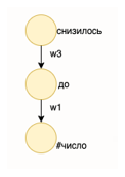

In [26]:
import cv2

def view_image(image_name):
  full_path = "/images/" + image_name
  image = cv2.imread(full_path)
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  plt.figure(figsize = (30,3))
  plt.imshow(image)
  plt.axis('off')
  plt.grid(False)

test_1 = 'Capture1.PNG'
print('Вариант 1 дерева:')
view_image(test_1)

Вариант 2 дерева:


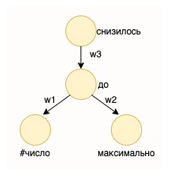

In [27]:
test_2 = 'Capture2.PNG'
print('Вариант 2 дерева:')
view_image(test_2)

Алгоритм поиска полных поддеревьев не выделит во втором дереве повторяющееся первое. В силу свободного порядка слов
на одном синтаксическом уровне, таких примеров очень много. Поэтому был написан алгоритм, который это учитывает.

Далее идет код для задачи поиска частичных поддеревьев.

Вспомогательные функции:

In [28]:
def contained_in_others(curr, dict_nodeid_comb):
    containing_only = {k: v for k, v in dict_nodeid_comb if any(elem in l for elem in curr for l in v)}
    dict_nodeid_comb_filtered = {k: list(filter(lambda x: len(x) == len(curr) + 1, v)) for k, v in
                                 containing_only.items()}
    boolean_is_contained = [any(elem in l for elem in curr for l in v) for _, v in dict_nodeid_comb_filtered.items()]
    return all(elem == True for elem in boolean_is_contained)


# update a label of a subtree with edge weight + a lemma of the last node
def insert_children_labels_to_parents(k_2, dict, tree):
    for k, v in dict.items():
        for v_id in list(v):
            edge_to_curr = Tree.get_edge(tree, v_id)
            if edge_to_curr is not None:
                label_for_child = str(edge_to_curr.weight) + str(k)
                if edge_to_curr.node_from not in k_2.keys():
                    k_2[edge_to_curr.node_from] = [label_for_child]
                else:
                    k_2[edge_to_curr.node_from].append(label_for_child)


In [29]:
def insert_nodeid_label_dict(lemma_nodeid_dict, whole_tree, v_id, curr_lemma):
    edge_to_curr = Tree.get_edge(whole_tree, v_id)
    if edge_to_curr is not None:
        label_for_child = str(edge_to_curr.weight) + str(curr_lemma)
        tup_id_sent = tuple([v_id, whole_tree.get_node(v_id).sent_name])
        if label_for_child not in lemma_nodeid_dict.keys():
            lemma_nodeid_dict[label_for_child] = [tup_id_sent]
        else:
            lemma_nodeid_dict[label_for_child].append(tup_id_sent)


def produce_combinations(k_2, v_id, lemma_nodeid_dict_local):
    all_combinations = [list(combinations(k_2[v_id], i)) for i in range(1, len(k_2[v_id]) + 1)]
    all_combinations_str_arr = [[str(item) for item in sorted(list(map(int, list(tup))))] for comb in all_combinations
                                for tup in comb]
    all_combinations_str_joined = []
    for combs in all_combinations_str_arr:
        joined_label = ''.join(combs)
        lemma_nodeid_dict_local[joined_label] = combs
        all_combinations_str_joined.append(joined_label)
    all_combinations_str_joined = [''.join(comb) for comb in all_combinations_str_arr]
    return all_combinations_str_joined

In [30]:
def get_nodeid_repeats(filtered_combination_ids, lemma_nodeid_dict_local):
    dict_nodeid_comb = {}
    for k, v in filtered_combination_ids.items():
        for v_i in v:
            if v_i in dict_nodeid_comb.keys():
                dict_nodeid_comb[v_i].append(lemma_nodeid_dict_local.get(k))
            else:
                dict_nodeid_comb[v_i] = [lemma_nodeid_dict_local.get(k)]
    return dict_nodeid_comb


def remove_duplicate_subtree_repeats(dict_nodeid_comb):
    for node_id, combs in dict_nodeid_comb.items():
        for curr in combs:
            if contained_in_others(curr, dict_nodeid_comb.items()):
                for _, v in dict_nodeid_comb.items():
                    if curr in v:
                        v.remove(curr)


def get_unique_subtrees_mapped(dict_nodeid_comb, lemma_count):
    unique_subtrees = set(tuple(x) for x in [sublist for list in list(dict_nodeid_comb.values()) for sublist in list])
    unique_subtrees_mapped = {}
    for subtree in unique_subtrees:
        lemma_count += 1
        unique_subtrees_mapped[subtree] = lemma_count
    return unique_subtrees_mapped, lemma_count


In [31]:
def classify_existing_node(curr_node, unique_subtrees_mapped, classes_subtreeid_nodes, node_subtrees):
    subtree_new_label = unique_subtrees_mapped.get(tuple(node_subtrees[0]))
    curr_node.lemma = subtree_new_label
    if curr_node.lemma not in classes_subtreeid_nodes.keys():
        classes_subtreeid_nodes[curr_node.lemma] = [curr_node.id]
    else:
        classes_subtreeid_nodes[curr_node.lemma].append(curr_node.id)


def remove_old_node(whole_tree, curr_node, grouped_heights, curr_height, k_2, lemma_nodeid_dict):
    edge_to_curr = Tree.get_edge(whole_tree, curr_node.id)
    node_from = edge_to_curr.node_from
    whole_tree.edges.remove(edge_to_curr)
    whole_tree.nodes.remove(curr_node)
    if curr_node in grouped_heights[curr_height][1]:
        grouped_heights[curr_height][1].remove(curr_node)
    del k_2[node_from]

    old_label = str(edge_to_curr.weight) + str(curr_node.lemma)
    old_node_id = curr_node.id
    nodes_with_old_label = lemma_nodeid_dict.get(old_label)
    return edge_to_curr, node_from, old_label, old_node_id, nodes_with_old_label

In [32]:
def create_new_node(total_nodes_count, whole_tree, node_from, edge_to_curr, subtree, curr_node,
                    k_2, unique_subtrees_mapped, grouped_heights, curr_height, old_node_id,
                    nodes_with_old_label, lemma_nodeid_dict):
    new_id = total_nodes_count
    Tree.add_edge(whole_tree, Edge(node_from, new_id, edge_to_curr.weight))
    subtree_new_label = unique_subtrees_mapped.get(tuple(subtree))
    new_node = Node(new_id, subtree_new_label, curr_node.form, curr_node.sent_name)
    Tree.add_node(whole_tree, new_node)
    grouped_heights[curr_height][1].append(new_node)
    new_label_for_child = str(edge_to_curr.weight) + str(subtree_new_label)
    if node_from not in k_2.keys():
        k_2[node_from] = [new_label_for_child]
    else:
        k_2[node_from].append(new_label_for_child)
    curr_sent = list(filter(lambda x: x[0] == old_node_id, nodes_with_old_label))[0][1]  # current sentence
    new_tup = tuple([new_node.id, curr_sent])
    if new_label_for_child not in lemma_nodeid_dict.keys():
        lemma_nodeid_dict[new_label_for_child] = [new_tup]
    else:
        lemma_nodeid_dict[new_label_for_child].append(new_tup)
    return new_id, subtree_new_label


def create_and_remove_edges_to_children(labl, lemma_nodeid_dict, curr_node, whole_tree, new_id):
    ids_same_label = lemma_nodeid_dict.get(labl)
    if ids_same_label is not None:
        curr = list(filter(lambda x: x[1] == curr_node.sent_name, ids_same_label))
        if len(curr) > 0:
            id_this_sent = curr[0][0]  # always only 1
            # except IndexError:
            #     omg = {}
            old_edge = Tree.get_edge(whole_tree, id_this_sent)
            if old_edge is not None:
                whole_tree.add_edge(Edge(new_id, id_this_sent, old_edge.weight))
                try:
                    whole_tree.edges.remove(old_edge)
                except ValueError as e:
                    Tree.remove_edge(whole_tree, old_edge.node_to)

Основная функция поиска частичных поддеревьев:

In [40]:
def compute_part_subtrees(whole_tree, lemma_count, grouped_heights):
    # compute subtree repeats
    classes_subtreeid_nodes = {}
    total_nodes_count = len(whole_tree.nodes)
    k_2 = {}  # identifiers of edges of subtrees
    # dictionary {lemma: [(node id with it, sentence),...,]}
    lemma_nodeid_dict = {}

    for nodes in grouped_heights:
        curr_height = nodes[0]
        print('Current height= ' + str(curr_height))
        start = time.time()
        id_lemma_dict = {node.id: node.lemma for node in nodes[1]}
        # group node ids of current height by lemmas
        grouped_lemmas = defaultdict(list)
        for key, value in id_lemma_dict.items():
            grouped_lemmas[value].append(key)
        # remember labels of subtrees
        insert_children_labels_to_parents(k_2, grouped_lemmas, whole_tree)
        # leave for processing only nodes with repeating lemmas on current height
        filtered_groups = list(filter(lambda x: len(x[1]) > 1, list(grouped_lemmas.items())))

        # for each group of nodes with the same lemma check which have the same subtrees
        for group in filtered_groups:
            curr_lemma = group[0]
            combination_ids = {}
            # same as lemma_nodeid_dict, but for current lemma
            lemma_nodeid_dict_local = {}
            # find all possible subtrees combinations and corresponding node ids
            for v_id in group[1]:
                # insert node with current lemma in lemma_nodeid_dict
                insert_nodeid_label_dict(lemma_nodeid_dict, whole_tree, v_id, curr_lemma)
                if curr_height != 0:  # not applicable to leaves, leaves don't have subtrees
                    # generate possible combinations of child nodes as possible subtree repeats
                    all_combinations_str_joined = produce_combinations(k_2, v_id, lemma_nodeid_dict_local)
                    # mapping nodes ids to combination
                    for label in all_combinations_str_joined:
                        if label in combination_ids.keys():
                            combination_ids[label].append(v_id)
                        else:
                            combination_ids[label] = [v_id]

            # if 1 vertex has n (more than 1) subtree repeats, it is replaced with n new nodes
            old_labels_to_remove = []  # remember which nodes were replaced and no longer needed

            if curr_height != 0:  # not applicable to leaves, leaves don't have subtrees
                # from attained combinations leave only repeating
                filtered_combination_ids = {k: v for k, v in combination_ids.items() if len(v) > 1}
                # do a reversed mapping to have a list of repeating subtrees for each node id
                # concretely, get a dictionary {node id: [[repeating subtree-1 nodes],..., [repeating subtree-N nodes]]}
                dict_nodeid_comb = get_nodeid_repeats(filtered_combination_ids, lemma_nodeid_dict_local)
                # for each node leave only non duplicating subtrees
                remove_duplicate_subtree_repeats(dict_nodeid_comb)
                # get unique subtrees for this height and assign them labels
                unique_subtrees_mapped, lemma_count = get_unique_subtrees_mapped(dict_nodeid_comb, lemma_count)

                # for each node iterate over its subtree repeats, assign them new labels and modify tree accordingly
                for node_id, node_subtrees in dict_nodeid_comb.items():
                    curr_node = Tree.get_node(whole_tree, node_id)
                    if len(node_subtrees) == 1:  # no need to create new nodes if there is only 1 subtree
                        # assign existing node a new label(lemma) as an identifier of a subtree
                        classify_existing_node(curr_node, unique_subtrees_mapped, classes_subtreeid_nodes,
                                               node_subtrees)
                    else:
                        # otherwise remove old vertex and edge to it and create new nodes (and edges)
                        edge_to_curr, node_from, old_label, old_node_id, nodes_with_old_label = \
                            remove_old_node(whole_tree, curr_node, grouped_heights, curr_height, k_2, lemma_nodeid_dict)

                        # mark to remove old node
                        old_labels_to_remove.append(old_label)

                        # iterate over repeated subtrees and create for each a new identifier (which includes current)
                        for subtree in node_subtrees:
                            # for every subtree create a new node
                            total_nodes_count += 1
                            new_id, subtree_new_label = create_new_node(total_nodes_count, whole_tree, node_from,
                                                                        edge_to_curr, subtree, curr_node,
                                                                        k_2, unique_subtrees_mapped, grouped_heights,
                                                                        curr_height, old_node_id,
                                                                        nodes_with_old_label, lemma_nodeid_dict)
                            # for each node in a repeat subtree
                            # for all its existing children remove previous edges and create new
                            for labl in subtree:
                                create_and_remove_edges_to_children(labl, lemma_nodeid_dict, curr_node, whole_tree,
                                                                    new_id)

                            # assign a class to a subtree
                            if subtree_new_label not in classes_subtreeid_nodes.keys():
                                classes_subtreeid_nodes[subtree_new_label] = [new_id]
                            else:
                                classes_subtreeid_nodes[subtree_new_label].append(new_id)
            # remove replaced nodes
            for to_remove in set(old_labels_to_remove):
                del lemma_nodeid_dict[to_remove]
        print('Time on current height: ' + str(time.time() - start))
    return classes_subtreeid_nodes

In [41]:
def main():
    trees_df_filtered = read_data()
    # TEST - тест на первых 3х предложениях (48 нод)
    trees_df_filtered = trees_df_filtered.head(5015)

    # get all lemmas and create a dictionary to map to numbers
    dict_lemmas = {lemma: index for index, lemma in enumerate(dict.fromkeys(trees_df_filtered['lemma'].to_list()), 1)}
    # get all relations and create a dictionary to map to numbers
    dict_rel = {rel: index for index, rel in enumerate(dict.fromkeys(trees_df_filtered['deprel'].to_list()))}
    train_word2vec(trees_df_filtered, dict_lemmas)

    start = time.time()
    whole_tree = construct_tree(trees_df_filtered, dict_lemmas, dict_rel)
    print('Time on constructing the tree: ' + str(time.time() - start))
    Tree.set_help_dict(whole_tree)
    # partition nodes by height
    start = time.time()
    Tree.calculate_heights(whole_tree)
    print('Time on calculating all heights: ' + str(time.time() - start))

    heights_dictionary = {Tree.get_node(whole_tree, node_id): height for node_id, height in
                          enumerate(whole_tree.heights)}
    grouped_heights = defaultdict(list)
    for key, value in heights_dictionary.items():
        grouped_heights[value].append(key)
    grouped_heights = sorted(grouped_heights.items(), key=lambda x: x[0])

    # classes for full repeats
    start = time.time()
    classes_full = compute_full_subtrees(whole_tree, len(dict_lemmas.keys()), grouped_heights)
    print('Time on calculating full repeats: ' + str(time.time() - start))
    for index, listt in enumerate(classes_full):
        vertex_seq = {}
        for vertex in listt:
            vertex_seq[vertex] = Tree.simple_dfs(whole_tree, vertex)
        # if len(vertex_seq.items()) > 0:
        filename = 'results_full/results_%s.txt' % (str(index))
        with open(filename, 'w') as filehandle:
            for key, value in vertex_seq.items():
                filehandle.write("%s: %s\n" % (key, value))
    dict_lemmas_size = max(set(map(lambda x: x.lemma, whole_tree.nodes)))

    # classes for partial repeats
    start = time.time()
    classes_part = compute_part_subtrees(whole_tree, dict_lemmas_size, grouped_heights)
    print('Time on calculating partial repeats: ' + str(time.time() - start))
    for k, v in classes_part.items():
        vertex_seq = {}
        for vertex in v:
            vertex_seq[vertex] = Tree.simple_dfs(whole_tree, vertex)
        if len(vertex_seq.items()) > 0:
            filename = 'results_part/results_%s.txt' % (str(k))
            with open(filename, 'w') as filehandle:
                for key, value in vertex_seq.items():
                    filehandle.write("%s: %s\n" % (key, value))

In [43]:
if __name__ == '__main__':
    main()

c:\users\varvara_koshman\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

c:\users\varvara_koshman\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\varvara_koshman\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by defau

Time on constructing the tree: 0.8896591663360596
Time on calculating all heights: 0.06486058235168457
Time on calculating full repeats: 0.6652240753173828
Current height= 0
Time on current height: 0.00598454475402832
Current height= 1
Time on current height: 0.14660882949829102
Current height= 2
Time on current height: 0.0718069076538086
Current height= 3
Time on current height: 0.15358924865722656
Current height= 4
Time on current height: 0.4916849136352539
Current height= 5
Time on current height: 0.39893221855163574
Current height= 6
Time on current height: 0.05289745330810547
Current height= 7
Time on current height: 0.0019562244415283203
Current height= 8
Time on current height: 0.008015871047973633
Current height= 9
Time on current height: 0.0
Current height= 10
Time on current height: 0.0
Current height= 11
Time on current height: 0.0
Current height= 12
Time on current height: 0.0
Current height= 13
Time on current height: 0.0
Current height= 14
Time on current height: 0.0
Curr